# 多头注意力

在实践中，当给定相同的查询、键和值的集合时，我们希望模型可以基于相同的注意⼒机制学习到不同的⾏
为，然后将不同的⾏为作为知识组合起来，例如捕获序列内各种范围的依赖关系（例如，短距离依赖和⻓距
离依赖）。因此，允许注意⼒机制组合使⽤查询、键和值的不同⼦空间表⽰（representation subspaces）可
能是有益的。

为此，与使⽤单独⼀个注意⼒汇聚不同，我们可以⽤独⽴学习得到的h 组不同的线性投影（linear projections）
来变换查询、键和值。然后，这h 组变换后的查询、键和值将并⾏地送到注意⼒汇聚中。最后，将这h 个注
意⼒汇聚的输出拼接在⼀起，并且通过另⼀个可以学习的线性投影进⾏变换，以产⽣最终输出。这种设计被称为多头注意⼒，其中h 个注意⼒汇聚输出中的每⼀个输出都被称作⼀个头（head）。

下图 展⽰了使⽤全连接层来实现可学习的线性变换的多头注意⼒。
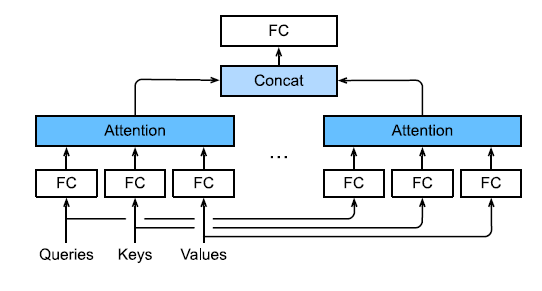


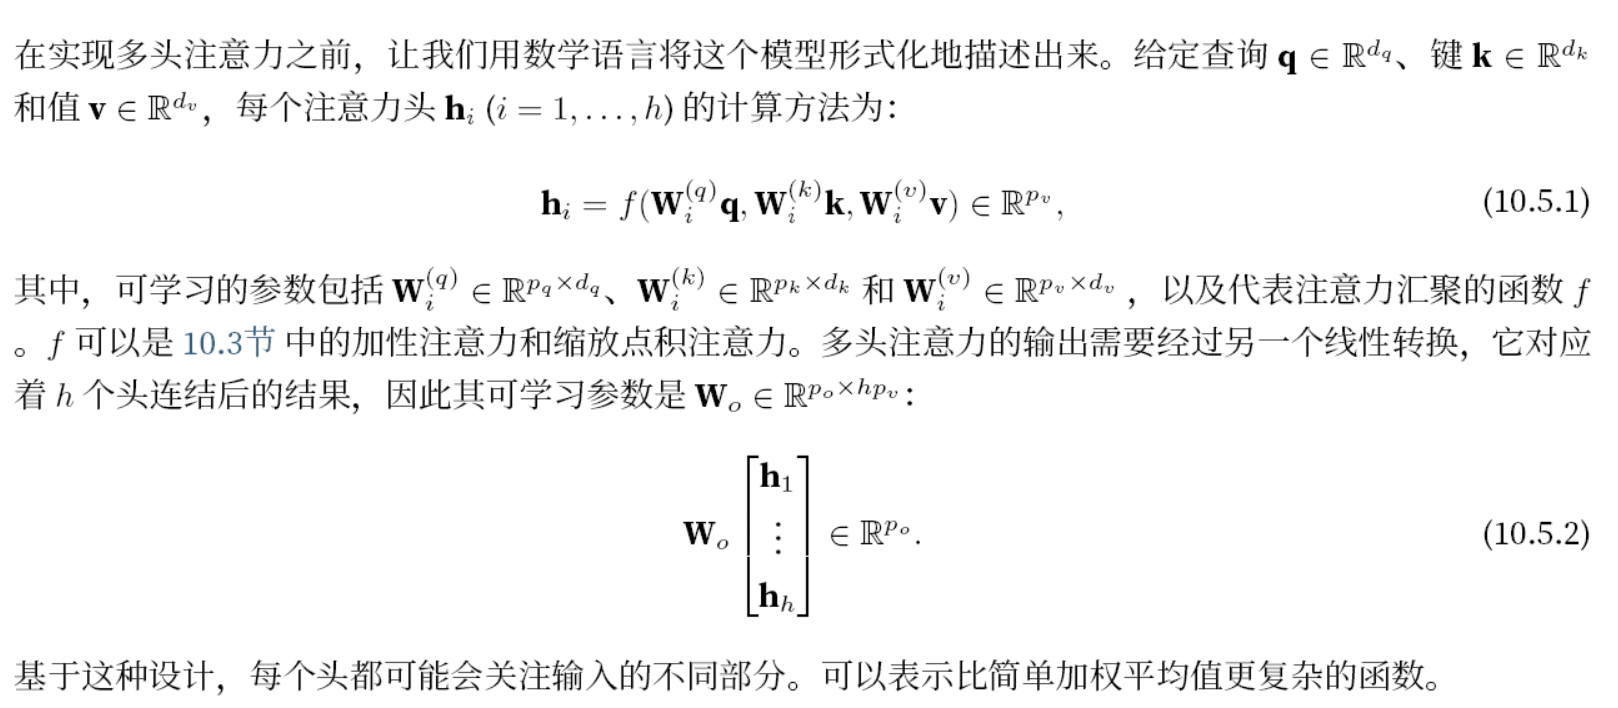

In [16]:
import math
import torch
from torch import nn
from d2l import torch as d2l

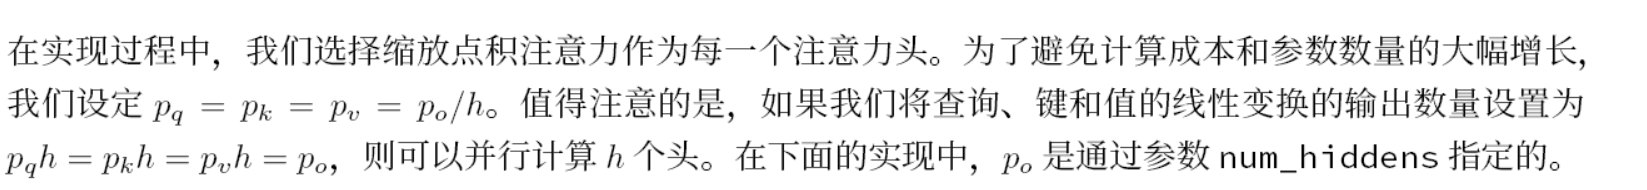

In [17]:
#@save

class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads # 多头的数量
        self.attention = d2l.DotProductAttention(dropout) # 缩放点积注意力
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias) # 将q,k,v经过全连接层
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)


    def forward(self, queries, keys, values, valid_lens):
        # `queries`, `keys`, or `values` 的形状:
        # (`batch_size`, 查询或者“键－值”对的个数, `num_hiddens`)
        # `valid_lens` 的形状:
        # (`batch_size`,) or (`batch_size`, 查询的个数)
        # 经过变换后，输出的  `queries`, `keys`, or `values` 的形状:
        # (`batch_size` * `num_heads`, 查询或者“键－值”对的个数,
        # `num_hiddens` / `num_heads`)
        
        # 使用transpose_qkv函数将q,k,v的形状改变，以便送入attention层中
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)


        if valid_lens is not None:
            # 在轴  0，将第⼀项（标量或者⽮量）复制  `num_heads` 次，
            # 然后如此复制第⼆项，然后诸如此类。
            valid_lens = torch.repeat_interleave( valid_lens, repeats=self.num_heads, dim=0)

        # `output` 的形状: (`batch_size` * `num_heads`, 查询的个数,
        # `num_hiddens` / `num_heads`)
        output = self.attention(queries, keys, values, valid_lens)

        # `output_concat` 的形状: (`batch_size`, 查询的个数, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)


In [18]:

#@save
def transpose_qkv(X, num_heads):
    # 输⼊ `X` 的形状: (`batch_size`, 查询或者“键－值”对的个数, `num_hiddens`).
    # 输出   `X` 的形状: (`batch_size`, 查询或者“键－值”对的个数, `num_heads`,
    # `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出   `X` 的形状: (`batch_size`, `num_heads`, 查询或者“键－值”对的个数,
    # `num_hiddens` / `num_heads`)
    X = X.permute(0, 2, 1, 3)

    # `output` 的形状: (`batch_size` * `num_heads`, 查询或者“键－值”对的个数,
    # `num_hiddens` / `num_heads`)
    return X.reshape(-1, X.shape[2], X.shape[3])


#@save
def transpose_output(X, num_heads):
    """逆转  `transpose_qkv` 函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


让我们使⽤键和值相同的小例⼦来测试我们编写的MultiHeadAttention 类。多头注意⼒输出的形状是
(batch_size, num_queries, num_hiddens)。

In [24]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [29]:
MultiHeadAttention(
    (attention): DotProductAttention((dropout): Dropout(p=0.5, inplace=False))
    (W_q): Linear(in_features=100, out_features=100, bias=False)
    (W_k): Linear(in_features=100, out_features=100, bias=False)
    (W_v): Linear(in_features=100, out_features=100, bias=False)
    (W_o): Linear(in_features=100, out_features=100, bias=False)
)

SyntaxError: invalid syntax (<ipython-input-29-029bafe51b3a>, line 2)

In [30]:
batch_size, num_queries, num_kvpairs, valid_lens = 2, 4, 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])